# Imports

In [2]:
# Basic imports
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# # Plotting and animations
import cartopy 
import cartopy.crs as ccrs
import math
import ipywidgets as widgets
import datetime
from IPython.display import HTML
from matplotlib import animation
from typing import Optional

# Model
from UNet import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Reshape

In [127]:
def plot_state(state, prediction=None, target=None):
    add = 0
    if prediction is not None:
        add += 1
    if target is not None:
        add += 1
        
    fig, ax = plt.subplots(1, state.shape[0] + add, figsize=(20, 5))
    for i in range(state.shape[0]):
        ax[i].imshow(state[i])
        ax[i].set_title(f'Input {i}')
        plt.colorbar(ax[i].imshow(state[i]), ax=ax[i])

    if prediction is not None:
        ax[state.shape[0]].imshow(prediction)
        ax[state.shape[0]].set_title('Prediction')
        plt.colorbar(ax[state.shape[0]].imshow(prediction), ax=ax[state.shape[0]])
                     
    if target is not None:
        ax[state.shape[0]- 1 + add].imshow(target)
        ax[state.shape[0]- 1 + add].set_title('Target')
        plt.colorbar(ax[state.shape[0] - 1 + add].imshow(target), ax=ax[state.shape[0]- 1 + add])

    plt.show()

def rollout(model, current_state, steps, input_shape, plot_shape, targets, plot = False):
    output = []
    for i in range(steps):
        pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)
        if plot:
            plot_state(current_state[0], prediction=pred, target=targets[i])
        current_state = current_state[:,1:]
        current_state = np.append(current_state, pred.reshape(1, 1, pred.shape[0], pred.shape[1]), axis=1)
        output.append(pred)

    return np.array(output).squeeze()

In [42]:
ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

# Data Check

In [7]:
def select(
    data: xr.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xr.Dataset:
  data = data[variable]
  # if "batch" in data.dims:
  #   data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  # if level is not None and "level" in data.coords:
  #   data = data.sel(level=level)
  return data

def scale(
    data: xr.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xr.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)

  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()
  
  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
      reference_date = datetime.datetime(1970, 1, 1)
      if "time" in first_data.dims:
        td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
        td = reference_date + td
        figure.suptitle(f"{fig_title}, {td.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=16)
      else:
        figure.suptitle(fig_title, fontsize=16)
      for im, (plot_data, norm, cmap) in zip(images, data.values()):
        im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

plot_size = 7
level = 1000

variable = 'ws'

data = {
    " ": scale(select(ds, variable, level, max_steps=5),
              robust=True),
}

fig_title = 'Wind Speed'

plot_data(data, fig_title, plot_size, robust=True)

# Data Preperation

In [173]:
# @title Data Preperation

window_size = 3
variable = 'ws'

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) 
y_ = np.array(y)

# Train Validation Split
split = round(X_.shape[0] * 0.9)

# Shape fixing
# lon_shape = ds.longitude.size
# lat_shape = ds.latitude.size

# Custom Shapes for the data
lon_shape = 64
lat_shape = 32
X_ = X_[:,:, 1:33, 3:67]
y_ = y_[:,1:33,3:67]

# Normalization
max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

# Splitting
f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
print('Train Shape: ', f_train.shape, t_train.shape, '\n\nTest Shape: ', f_test.shape, t_test.shape)

X_n = X_n.reshape(-1, lat_shape, lon_shape, window_size)
y_n = y_n.reshape(-1, lat_shape, lon_shape,  1)

f_training, t_training = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_testing, t_testing = X_n[split:].astype('float32'), y_n[split:].astype('float32')

Train Shape:  (7881, 3, 32, 64) (7881, 32, 64) 

Test Shape:  (876, 3, 32, 64) (876, 32, 64)


# Build Model

In [156]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  
    
    model = Model(inputs, outputs, name="U-Net")
    return model
# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024) #Bridge

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  
    
#     model = Model(inputs, outputs, name="U-Net")
#     return model

In [174]:
input_shape = tuple((1, lat_shape, lon_shape, window_size))
plot_shape = t_training[0].shape
output_shape = t_train.shape[1:] 

kernel_size = (1, 3)
pool_size = (2,2)
model = build_unet(input_shape[1:])

if True:
    model.summary()  
else:
    print('Done with output: ', model.predict(f_train[0:1].reshape(input_shape)).shape)  


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 32, 64, 3)]          0         []                            
                                                                                                  
 conv2d_221 (Conv2D)         (None, 32, 64, 32)           896       ['input_13[0][0]']            
                                                                                                  
 batch_normalization_210 (B  (None, 32, 64, 32)           128       ['conv2d_221[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_210 (Activation  (None, 32, 64, 32)           0         ['batch_normalization_210[

# Error Metric

In [187]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# model.load_weights('models/model.h5')
model.load_weights('models\weather_model_27mb_ws_3.h5')
seed = 60
steps = 24

targets = t_test[seed:steps + seed]

rollout_pred = rollout(model, f_test[seed:seed+ 1], steps, input_shape, plot_shape, targets, plot=False)

rollout_pred = rollout_pred * max_ws
targets = targets * max_ws

mse = mean_squared_error(targets.flatten(), rollout_pred.flatten())
mae = mean_absolute_error(targets.flatten(), rollout_pred.flatten())
mape = mean_absolute_percentage_error(targets.flatten(), rollout_pred.flatten())
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Mean Absolute Percentage Error: {mape}, Root Mean Squared Error: {rmse}')

1/1 [==============================] - 0s 51ms/step
Mean Squared Error: 16.66200828552246, Mean Absolute Error: 3.169650077819824, Mean Absolute Percentage Error: 0.6528708338737488, Root Mean Squared Error: 4.081912517547607


In [188]:
# Create DataSet

latitudes = ds.latitude[1:33]
longitudes = ds.longitude[3:67]
time = ds.time[seed:seed+steps]

rollout_pred_da = xr.DataArray(rollout_pred, dims=('time', 'latitude', 'longitude'),
                               coords={'time': time, 'latitude': latitudes, 'longitude': longitudes})
target_da = xr.DataArray(targets, dims=('time', 'latitude', 'longitude'),
                                 coords={'time': time, 'latitude': latitudes, 'longitude': longitudes})
latitudes_da = xr.DataArray(latitudes, dims=('latitude'), coords={'latitude': latitudes})
longitudes_da = xr.DataArray(longitudes, dims=('longitude'), coords={'longitude': longitudes})
time_da = xr.DataArray(time, dims=('time'), coords={'time': time})

# Create xarray Dataset
ds_new = xr.Dataset({'rollout_pred': rollout_pred_da, 'target': target_da})
ds_new['time'] = time_da



Mean Squared Error: 5.225956439971924, Mean Absolute Error: 2.058656930923462, Mean Absolute Percentage Error: 0.308631032705307, Root Mean Squared Error: 2.2860350608825684


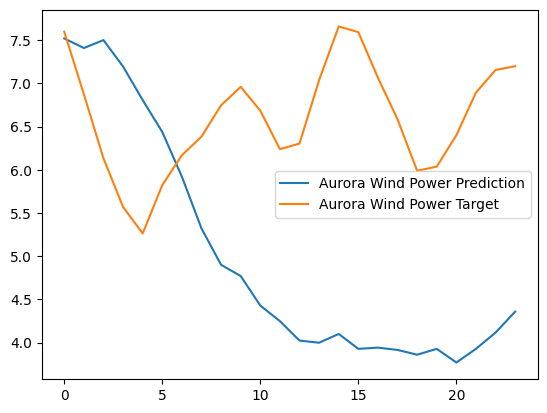

Mean Squared Error: 7.082376480102539, Mean Absolute Error: 2.0516886711120605, Mean Absolute Percentage Error: 0.581109344959259, Root Mean Squared Error: 2.66127347946167


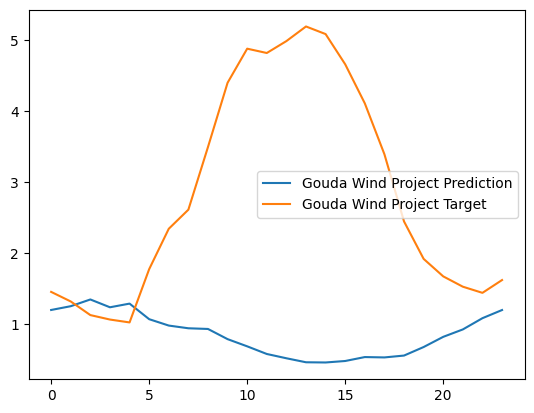

Mean Squared Error: 43.432064056396484, Mean Absolute Error: 5.461519241333008, Mean Absolute Percentage Error: 0.79874187707901, Root Mean Squared Error: 6.590300559997559


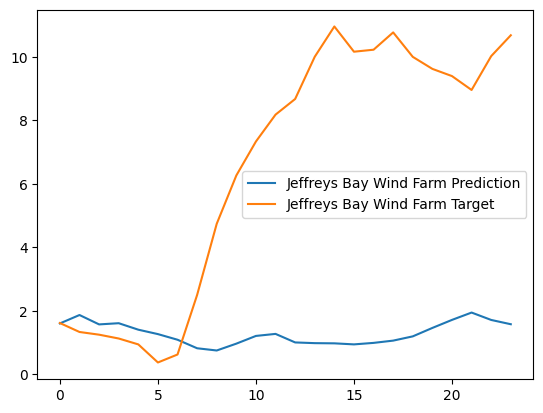

Mean Squared Error: 17.834699630737305, Mean Absolute Error: 3.4256885051727295, Mean Absolute Percentage Error: 0.923281729221344, Root Mean Squared Error: 4.223114967346191


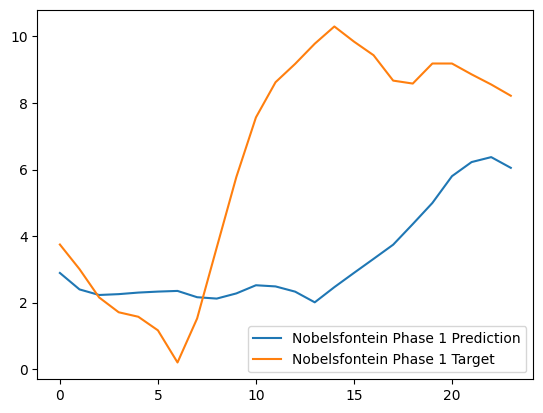

Mean Squared Error: 16.19024085998535, Mean Absolute Error: 3.856300115585327, Mean Absolute Percentage Error: 0.5981998443603516, Root Mean Squared Error: 4.023709774017334


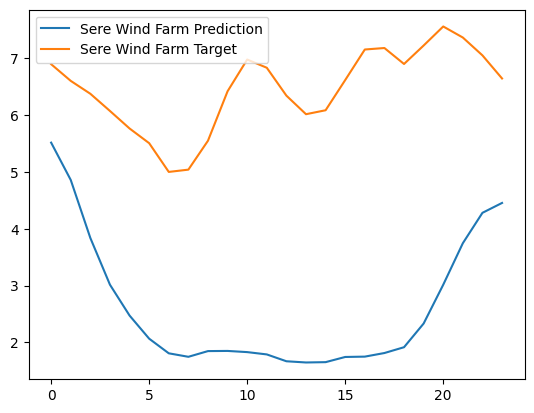

In [189]:
# Compare areas

wind_farms = [
    # {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    # {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    # {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    # {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    # {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    # {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    # {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    # {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    # {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    # {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    # {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    # {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    # {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    # {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    # {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    # {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    # {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    # {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    # {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    # {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    # {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    # {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    # {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    # {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    # {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    # {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    # {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    # {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    # {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

color = ['b', 'g', 'r', 'c', 'k']

for wind_farm in wind_farms:
    latitude, longitude = wind_farm['location']
    name = wind_farm['name']

    pred = ds_new.sel(latitude=latitude, longitude=longitude, method='nearest')['rollout_pred']
    target = ds_new.sel(latitude=latitude, longitude=longitude, method='nearest')['target']

    plt.plot(pred, label=f'{name} Prediction')
    plt.plot(target, label=f'{name} Target')
    plt.legend()

    mse, mae, mape, rmse = mean_squared_error(target, pred), mean_absolute_error(target, pred), mean_absolute_percentage_error(target, pred), np.sqrt(mean_squared_error(target, pred))
    print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Mean Absolute Percentage Error: {mape}, Root Mean Squared Error: {rmse}')
    plt.show()